In [23]:
from src.config import RAW_DATA_DIR

channel = 0
# database = "afdb"
# record = "04015"
# database = "mitdb"
# record = "102"
# database = "2017_challenge"
# record = "data_22_12"
# database = "long_term"
# record = "44"
database = "af-termination-challenge"
record = "b03"

In [24]:
import wfdb
from pathlib import Path

# Define the paths
record_path = RAW_DATA_DIR / database / record

# Load the WFDB record and its annotations
record_data = wfdb.rdrecord(str(record_path))
try:
    annotation = wfdb.rdann(str(record_path), 'atr')
except:
    annotation = None

# Try to load the QRS annotation if it exists
qrs_annotation_path = record_path.with_suffix('.qrs')
if qrs_annotation_path.exists():
    qrs_annotation = wfdb.rdann(str(record_path), 'qrs')
else:
    qrs_annotation = None
print(qrs_annotation)

### Resamplowanie

In [25]:
from wfdb import processing
import numpy as np

def resample_data_and_annotations(record_data, annotation, qrs_annotation, target_fs):
    if record_data is None:
        signal = np.zeros((10, 1))
        try:
            fs = annotation.fs
        except:
            try:
                fs = qrs_annotation.fs
            except:
                raise ValueError("No fs attribute found in the annotations")
    else:
        signal = record_data.p_signal
        fs = record_data.fs

    if annotation is None:
        note = wfdb.Annotation("xd", "atr", np.zeros((10, 1)))
    else:
        note = annotation

    # Resample the record data
    resampled_record, resampled_annotation = processing.resample_multichan(signal, note, fs, target_fs)
    
    # Resample the QRS annotation if it exists
    if qrs_annotation is not None:
        _, resampled_qrs_annotation = processing.resample_multichan(signal, qrs_annotation, fs, target_fs)
    else:
        resampled_qrs_annotation = None
    
    resampled_record = resampled_record if record_data is not None else None
    resampled_annotation = resampled_annotation if annotation is not None else None
    return resampled_record, resampled_annotation, resampled_qrs_annotation

target_fs = 125
resampled_record, resampled_annotation, resampled_qrs_annotation = resample_data_and_annotations(record_data, annotation, qrs_annotation, target_fs)

### QRS i RR

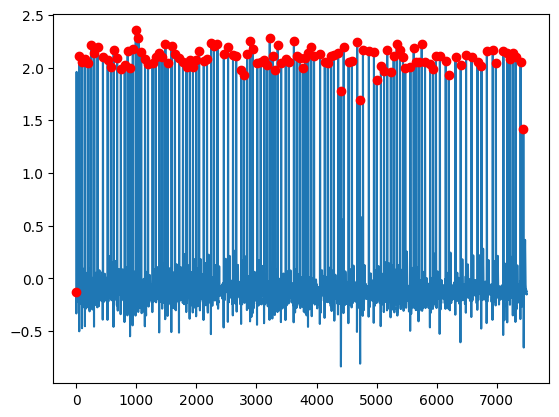

In [26]:
import matplotlib.pyplot as plt

def calculate_rr(qrs_locs, fs):
    # Calculate RR intervals using wfdb.processing.calc_rr
    rr_intervals = wfdb.processing.calc_rr(qrs_locs, fs)
    return rr_intervals

def correct_qrs_locs(signal, channel, qrs_locs, fs):
    qrs_indices = processing.correct_peaks(
        signal[:, channel], qrs_locs, search_radius=int(0.1 * fs), smooth_window_size=150
    )
    return qrs_indices

# Calculate RR intervals for the given annotation
if database == "mitdb":
    qrs_locs = resampled_annotation.sample
elif database == "afdb":
    qrs_locs = resampled_qrs_annotation.sample
elif database == "af-termination-challenge":
    qrs_locs = resampled_qrs_annotation.sample
elif database == "2017_challenge":
    qrs_locs = resampled_annotation.sample
elif database == "long_term":
    qrs_locs = resampled_qrs_annotation.sample

if resampled_record is not None:
    qrs_locs = correct_qrs_locs(resampled_record, channel, qrs_locs, target_fs)
original_qrs_locs = qrs_locs.copy()
rr_intervals = calculate_rr(qrs_locs, target_fs)

plt.plot(resampled_record[:, channel])
plt.plot(qrs_locs[:], resampled_record[qrs_locs[:], channel], 'ro')
# plt.xlim(0, 1000)
plt.show()

### Etykiety

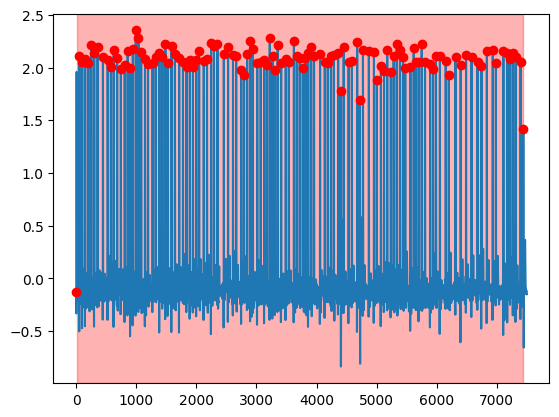

In [27]:
import numpy as np

def find_afib_segments(annotation):
    afib_segments = []
    in_afib = False
    start = None

    for i, note in enumerate(annotation.aux_note):
        # Ignoruj puste notatki
        if note == '' or note == 'None':
            continue

        # Sprawdzenie, czy zaczyna się AFIB
        if 'AFIB' in note and not in_afib:
            start = annotation.sample[i]
            in_afib = True
        
        # Sprawdzenie, czy AFIB kończy się (kiedy pojawia się inny rytm)
        elif 'AFIB' not in note and in_afib:
            end = annotation.sample[i]
            afib_segments.append((start, end))
            in_afib = False

    # Jeśli AFIB trwa do końca adnotacji
    if in_afib:
        afib_segments.append((start, annotation.sample[-1]))

    return afib_segments

def mark_rr_intervals(qrs_locs, afib_segments):
    afib_labels = []

    for i in range(len(qrs_locs) - 1):
        start, end = qrs_locs[i], qrs_locs[i + 1]
        total_samples = end - start

        # Sprawdź, czy przedział pokrywa się z którymś segmentem AFIB
        for afib_start, afib_end in afib_segments:
            overlap_start = max(start, afib_start)
            overlap_end = min(end, afib_end)

            if overlap_start < overlap_end:  # Jest pokrycie
                afib_samples = overlap_end - overlap_start
                if afib_samples > total_samples / 2:  # AFIB w większości przedziału
                    afib_labels.append(1)
                    break
        else:
            # Brak pokrycia lub za małe pokrycie
            afib_labels.append(0)

    return np.array(afib_labels).reshape(-1, 1).squeeze()

try:
    afib_count = sum('AFIB' in note for note in resampled_annotation.aux_note)
    print(f"Liczba notów z 'AFIB': {afib_count}")
except:
    pass

if resampled_annotation is not None:
    afib_segments = find_afib_segments(resampled_annotation)
else:
    afib_segments = [(resampled_qrs_annotation.sample[0], resampled_qrs_annotation.sample[-1])]
labels = mark_rr_intervals(qrs_locs, afib_segments)

x_start = 4520000
x_end = 4521000

plt.figure()
plt.plot(resampled_record[:, channel])
plt.plot(qrs_locs[:], resampled_record[qrs_locs[:], channel], 'ro')
for start, end in afib_segments:
    plt.axvspan(start, end, color='red', alpha=0.3)

# plt.xlim(x_start, x_end)
plt.show()

# plt.figure()
# plt.plot(resampled_record[:, channel])
# plt.plot(qrs_locs[:], resampled_record[qrs_locs[:], channel], 'ro')
# for i, label in enumerate(labels):
#     if label == 1:  # Jeśli przedział zawiera AFIB
#         start, end = qrs_locs[i], qrs_locs[i + 1]
#         plt.axvspan(start, end, color='red', alpha=0.3)

# # plt.xlim(x_start, x_end)
# plt.show()

# print(len(rr_intervals))
# print(len(labels))

### Podział na chunki

In [28]:
import numpy as np

def split_into_chunks_truncate(rr_intervals, labels, chunk_size):
    n = len(rr_intervals)
    num_chunks = n // chunk_size
    
    truncated_rr_intervals = rr_intervals[:num_chunks * chunk_size]
    truncated_labels = labels[:num_chunks * chunk_size]
    
    rr_chunks = truncated_rr_intervals.reshape(num_chunks, chunk_size)
    label_chunks = truncated_labels.reshape(num_chunks, chunk_size)
    
    return rr_chunks, label_chunks


rr_chunks, label_chunks = split_into_chunks_truncate(rr_intervals, labels, 64)
print(rr_chunks.shape)
# for i in range(rr_chunks.shape[0]):
#     print(label_chunks[i].shape)
#     plt.plot(rr_chunks[i])
#     plt.show()

(1, 64)
